<a href="https://colab.research.google.com/github/JumpNShootMan/TP_MachineLearning/blob/master/TP_ML_Decision_Tree_Classifier_%26_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 171kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 147kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import cv2
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/JumpNShootMan/TP_MachineLearning/master/datos_banco.csv', encoding='latin-1')

data.head(10)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125000,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375000,FEMALE,S,NORMAL,Secundaria,0,0
2,LIBDISP4057314971,0,491.5,64.0,"1,000",3,84.99,2082.196667,FEMALE,S,NORMAL,Secundaria,0,0
3,LIBDISP8375185888,0,848.65,77.0,"1,500",6,221.53,3422.423333,MALE,S,NORMAL,Universitaria,0,0
4,LIBDISP9694463037,0,470.52,82.0,"1,000",3,91.34,1882.090000,FEMALE,S,NORMAL,Universitaria,1,0
5,LIBDISP0492929616,0,490.77,79.0,"1,500",6,221.53,2448.016667,MALE,S,NORMAL,Carrera TÃÂ©cnica,1,0
6,LIBDISP6813272232,0,428.57,71.0,"4,000",12,"1,109.56",1803.923333,FEMALE,S,NORMAL,Universitaria,0,0
7,LIBDISP8862427268,1,647.87,4.0,"1,200",6,289.11,2660.630000,MALE,S,NORMAL,Secundaria,1,0
8,LIBDISP7167831610,0,694.23,NaN,900,6,149.79,2912.158333,FEMALE,C,CPP,Universitaria,1,0
9,LIBDISP3835927929,1,209.48,77.0,"1,000",6,152.32,2498.043333,MALE,S,NORMAL,Secundaria,1,0


In [ ]:
data.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity             object
var_employment_time_in_months    float64
approved_amount                   object
approved_term                      int64
approved_interest_amount          object
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

# Pre-procesamiento

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

Eliminación de atributos innecesarios para la tarea de clasificación. 'idPrestamo' por ser un indice y 'default_request_amount' por solo tener data de uno de sus valores '0'.

In [ ]:
del data["idPrestamo"]
del data["default_request_amount"]

Union de las instancias con valor 'Carrera TÃÂ©cnica' y 'Carrera TÌÄå©cnica' en un solo valor 'Carrera Tecnica'.

In [ ]:
for i in range(len(data['person_degree_type_desc'])):
  if data['person_degree_type_desc'][i] == "Carrera TÃÂ©cnica" or data['person_degree_type_desc'][i] == "Carrera TÌÄå©cnica":
    data['person_degree_type_desc'][i] = "Carrera Tecnica"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


OneHotEnconding para los atributos cualitativos.

In [ ]:
def oneHotEncoding(feature):
  onehot_encoded = pd.get_dummies(data[feature], prefix=feature)
  del data[feature]
  return data.join(onehot_encoded)

In [ ]:
data = oneHotEncoding('person_gender')
data = oneHotEncoding('credit_history_marital_status')
data = oneHotEncoding('var_max_sbs_qual_12m')
data = oneHotEncoding('person_degree_type_desc')

Transformación de los valores tipo object a valores numéricos.

In [ ]:
for i in data:
  for j in range(len(data[i])):
    if type(data[i][j]) == str:
      data[i][j] = data[i][j].replace(',', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for i in data:
  if data[i].dtype == object:
    data[i] = pd.to_numeric(data[i])

Remplazo de valores faltantes utilizando SimpleImputer.

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data.var_employment_time_in_months = imputer.fit_transform(data['var_employment_time_in_months'].values.reshape(-1,1))

Normalización MinMax para los valores que originalmente eran cuantitativos, excepto 'approved_term' porque son meses.

In [ ]:
def standardization(feature):
  scaler = MinMaxScaler()
  return scaler.fit_transform(data[feature].values.reshape(-1,1))

In [ ]:
data['monthly_debt_capacity'] = standardization('monthly_debt_capacity')
data['var_employment_time_in_months'] = standardization('var_employment_time_in_months')
data['approved_amount'] = standardization('approved_amount')
data['approved_interest_amount'] = standardization('approved_interest_amount')
data['var_net_income'] = standardization('var_net_income')

In [ ]:
data.head(10)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,person_gender_FEMALE,person_gender_MALE,credit_history_marital_status_C,credit_history_marital_status_D,credit_history_marital_status_S,credit_history_marital_status_V,var_max_sbs_qual_12m_CPP,var_max_sbs_qual_12m_DEFICIENTE,var_max_sbs_qual_12m_DUDOSO,var_max_sbs_qual_12m_NORMAL,var_max_sbs_qual_12m_PERDIDA,person_degree_type_desc_Carrera Tecnica,person_degree_type_desc_Postgrado,person_degree_type_desc_Primaria,person_degree_type_desc_Secundaria,person_degree_type_desc_Universitaria
0,1,0.055545,0.113636,0.059829,6,0.116370,0.039883,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.054488,0.579545,0.145299,12,0.294249,0.037128,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0.087848,0.738636,0.042735,3,0.027169,0.072837,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.136099,0.886364,0.085470,6,0.086837,0.119720,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,0.085014,0.943182,0.042735,3,0.029944,0.065837,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0.087750,0.909091,0.085470,6,0.086837,0.085634,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0.079347,0.818182,0.299145,12,0.474912,0.063103,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
7,1,0.108974,0.056818,0.059829,6,0.116370,0.093071,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
8,0,0.115237,0.397495,0.034188,6,0.055487,0.101870,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
9,1,0.049748,0.886364,0.042735,6,0.056592,0.087384,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
data.to_csv('datos_banco_post.csv')

# Validación de modelos

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

Separación de la data y los labels.

In [ ]:
X = data.iloc[:,1:]
y = data.target

Separación de la data con 20% de test y 80% para train.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

Creación del modelo, predicción de la test data, impresión de la matriz de confusión y reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[171  67]
 [ 63  43]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       238
           1       0.39      0.41      0.40       106

    accuracy                           0.62       344
   macro avg       0.56      0.56      0.56       344
weighted avg       0.63      0.62      0.62       344



Reporte del 'accuracy' resultante de cada fold y su promedio.


In [ ]:
scores = cross_val_score(tree, X, y, cv=5)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.6017441860465116
2: 0.6511627906976745
3: 0.6598837209302325
4: 0.6075581395348837
5: 0.6034985422740525
Promedio: 0.6247694758966709


Función para graficar las curvas de validación.

In [ ]:
def plotingValidationCurve(model, X, y, param_name, param_range, cv, scoring):
  train_scores, valid_scores = validation_curve(
    model, X, y, param_name=param_name, param_range=param_range,
    cv=cv, scoring=scoring)

  mean_training = np.mean(train_scores, axis=1) 
  mean_validation = np.mean(valid_scores, axis=1) 

  plt.plot(param_range, mean_training, '--', color="b",  label="Train score")
  plt.plot(param_range, mean_validation, color="g", label="Validation score")
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.legend(loc="best")
  plt.show()

Curva de validación del parametro 'max_depth', el mejor accuracy es obtenido por una profundidad maxima de 3.

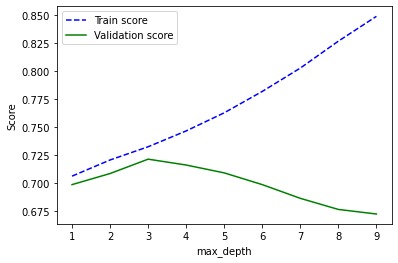

In [ ]:
plotingValidationCurve(tree, X, y, 'max_depth', np.arange(1, 10), 5, 'accuracy')

Curva de validación del parametro 'min_samples_leaf', los valores 100, 110, 120 son los más prometedores porque obtuvieron buen accuracy y son los resultados más cercanos a la curva de entrenamiento.

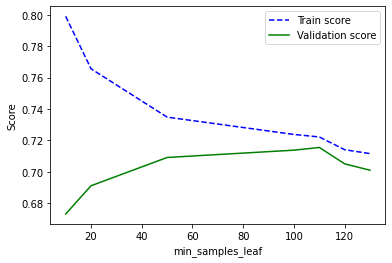

In [ ]:
param_range = [10, 20, 50, 100, 110, 120, 130]

plotingValidationCurve(tree, X, y, 'min_samples_leaf', param_range, 5, 'accuracy')

Función para graficar las curvas de aprendizaje.

In [ ]:
def plotingLearningCurve(model, X, y, train_sizes, cv, scoring):
  train_sizes, train_scores, valid_scores = learning_curve(
    model, X, y, scoring=scoring, 
    train_sizes=train_sizes, cv=cv) 

  mean_training = np.mean(train_scores, axis=1) 
  mean_validation = np.mean(valid_scores, axis=1) 

  plt.plot(train_sizes, mean_training, '--', color="b",  label="Train score") 
  plt.plot(train_sizes, mean_validation, color="g", label="Validation score") 
    
  plt.xlabel("Training Set Size") 
  plt.ylabel("Accuracy Score") 
  plt.legend(loc="best") 
  plt.show()

Curva de aprenizaje del modelo, se observa que la curva de entrenamiento esta al maximo de score lo que indica overfitting. Por otro lado, la curva del cross-validation es muy variable a lo largo de las iteraciones. Además, entre las curvas hay mucha diferencia lo que indica un escenario de alta varianza. Es recomendable consegir más data o reducir la complejidad del modelo para mejorar el performance de este.

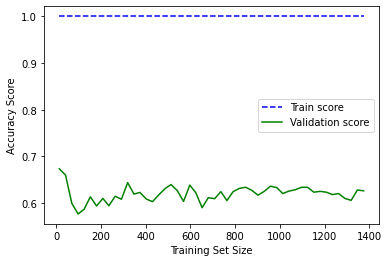

In [ ]:
plotingLearningCurve(tree, X, y, np.linspace(0.01, 1.0, 50), 5, 'accuracy')

Definición de los valores posibles para los hiperparámetros del modelo con valores de prueba obtenido de las curvas de validación.

In [ ]:
param_grid = {'criterion':['gini','entropy'], 'max_depth':np.arange(1, 5), 'min_samples_leaf':[100, 110, 120]}

Realizamos una busqueda de valores para los hiperparámetros especificados mediante GriSearchCV.

In [ ]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

Imprimimos el mejor estimador encontrado en la busqueda.

In [ ]:
print(grid.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=110, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Empleamos el mejor modelo para realizar una predicción del test data. También, imprimimos la matriz de confusión y el reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[206  32]
 [ 69  37]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       238
           1       0.54      0.35      0.42       106

    accuracy                           0.71       344
   macro avg       0.64      0.61      0.61       344
weighted avg       0.68      0.71      0.69       344



Reporte del 'accuracy' resultante de cada fold y su promedio.

In [ ]:
scores = cross_val_score(model, X, y, cv=5)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.7093023255813954
2: 0.7005813953488372
3: 0.7151162790697675
4: 0.7325581395348837
5: 0.7201166180758017
Promedio: 0.7155349515221371


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Creación del modelo, predicción de la test data, impresión de la matriz de confusión y reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [ ]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[230   8]
 [ 95  11]]
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       238
           1       0.58      0.10      0.18       106

    accuracy                           0.70       344
   macro avg       0.64      0.54      0.50       344
weighted avg       0.67      0.70      0.62       344



Reporte del 'accuracy' resultante de cada fold y su promedio.


In [ ]:
scores = cross_val_score(NB, X, y, cv=5)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.7151162790697675
2: 0.7034883720930233
3: 0.7238372093023255
4: 0.7151162790697675
5: 0.7259475218658892
Promedio: 0.7167011322801546


Curva de validación del parametro 'alpha', observamos que las curvas de juntan con un alpha cercano a 7. Sin embargo, el mejor accuraccy es cercano a 0.

In [ ]:
alpha = [0.01, 0.1, 0.5, 1.0, 10.0]

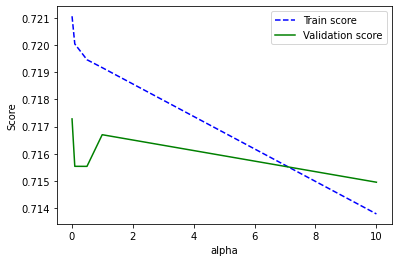

In [ ]:
plotingValidationCurve(NB, X, y, 'alpha', alpha, 5, 'accuracy')

Curva de aprenizaje del modelo, se observa que las curvas son muy cercanas los que indica un caso de varianza baja. Pero el accuracy obtenido es muy bajo lo cual es incador de alto sesgo. Es recomendable conseguir más data para reducir la inclinación existente.

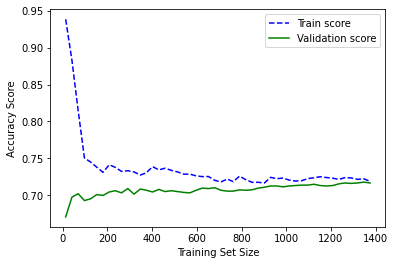

In [ ]:
plotingLearningCurve(NB, X, y, np.linspace(0.01, 1.0, 50), 5, 'accuracy')

Definición de los valores posibles para los hiperparámetros del modelo con valores de prueba obtenido de las curvas de validación.

In [ ]:
np.linspace(0.1,8,20)

array([0.1       , 0.51578947, 0.93157895, 1.34736842, 1.76315789,
       2.17894737, 2.59473684, 3.01052632, 3.42631579, 3.84210526,
       4.25789474, 4.67368421, 5.08947368, 5.50526316, 5.92105263,
       6.33684211, 6.75263158, 7.16842105, 7.58421053, 8.        ])

In [ ]:
param_grid = {'alpha': np.linspace(0.1,3,20)}

Realizamos una busqueda de valores para los hiperparámetros especificados mediante GriSearchCV.

In [ ]:
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1       , 0.25263158, 0.40526316, 0.55789474, 0.71052632,
       0.86315789, 1.01578947, 1.16842105, 1.32105263, 1.47368421,
       1.62631579, 1.77894737, 1.93157895, 2.08421053, 2.23684211,
       2.38947368, 2.54210526, 2.69473684, 2.84736842, 3.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Imprimimos el mejor estimador encontrado en la busqueda.

In [ ]:
print(grid.best_estimator_)

MultinomialNB(alpha=1.3210526315789475, class_prior=None, fit_prior=True)


Empleamos el mejor modelo para realizar una predicción del test data. También, imprimimos la matriz de confusión y el reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[231   7]
 [ 95  11]]
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       238
           1       0.61      0.10      0.18       106

    accuracy                           0.70       344
   macro avg       0.66      0.54      0.50       344
weighted avg       0.68      0.70      0.62       344



Reporte del 'accuracy' resultante de cada fold y su promedio.

In [ ]:
scores = cross_val_score(model, X, y, cv=5)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.7151162790697675
2: 0.7093023255813954
3: 0.7267441860465116
4: 0.7180232558139535
5: 0.7259475218658892
Promedio: 0.7190267136755035
